# SARIMAX Forecasting Model (Model A - Seasonality Focus)

This notebook implements SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) for time series forecasting.

## SARIMAX Advantages
- **Statistical Rigor**: Well-established statistical foundation
- **Seasonal Patterns**: Explicitly models seasonal components
- **Interpretable**: Clear mathematical formulation
- **Diagnostic Tools**: Extensive residual analysis capabilities

## Configuration
- **ARIMA Order**: (p, d, q) - To be determined by ACF/PACF
- **Seasonal Order**: (P, D, Q, s) with s=12 for monthly data
- **Differencing**: Test for stationarity
- **Model Selection**: AIC/BIC comparison

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load Time Series Data

In [2]:
# Load company-level time series
data_path = Path('../data/processed/monthly_aggregated_full_company.parquet')

if not data_path.exists():
    data_path = Path('../data/processed/monthly_aggregated_full_company.csv')
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
else:
    df = pd.read_parquet(data_path)

df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded: {len(df)} months ({df['date'].min()} to {df['date'].max()})")

Loaded: 36 months (2022-01-01 00:00:00 to 2024-12-01 00:00:00)


## Section 2: Train/Validation Split

In [3]:
target_metrics = [
    'total_orders',
    'total_km_billed',
    'total_km_actual',
    'total_tours',
    'total_drivers',
    'revenue_total',
    'external_drivers',
    'vehicle_km_cost',      # NEW: KM-based transportation cost
    'vehicle_time_cost',    # NEW: Time-based transportation cost
    'total_vehicle_cost'    # NEW: Total vehicle operational cost
]

# Backward compatibility check
if 'total_km' in df.columns and 'total_km_billed' not in df.columns:
    target_metrics = [m.replace('total_km_billed', 'total_km') if m == 'total_km_billed' else m for m in target_metrics]
    target_metrics = [m for m in target_metrics if m != 'total_km_actual']  # Remove if not available

In [4]:
# Split data: Last 6 months as validation
split_date = '2024-07-01'

train_df = df[df['date'] < split_date].copy()
val_df = df[df['date'] >= split_date].copy()

# Define validation period date boundaries (needed for forecast extraction)
val_start = pd.to_datetime('2024-07-01')
val_end = pd.to_datetime('2024-12-01')
train_end = pd.to_datetime('2024-06-01')

print(f"\n✓ Split complete!")
print(f"  Training: {len(train_df)} months (Jan 2022 - Jun 2024)")
print(f"  Validation: {len(val_df)} months (Jul 2024 - Dec 2024)")


✓ Split complete!
  Training: 30 months (Jan 2022 - Jun 2024)
  Validation: 6 months (Jul 2024 - Dec 2024)


## Section 3: Stationarity Testing

Use Augmented Dickey-Fuller test to check if series is stationary.

In [5]:
target_metrics = [
    'total_orders',
    'total_km_billed',
    'total_km_actual',
    'total_tours',
    'total_drivers',
    'revenue_total',
    'external_drivers',
    'vehicle_km_cost',      # NEW: KM-based transportation cost
    'vehicle_time_cost',    # NEW: Time-based transportation cost
    'total_vehicle_cost'    # NEW: Total vehicle operational cost
]

# Backward compatibility check
if 'total_km' in df.columns and 'total_km_billed' not in df.columns:
    target_metrics = [m.replace('total_km_billed', 'total_km') if m == 'total_km_billed' else m for m in target_metrics]
    target_metrics = [m for m in target_metrics if m != 'total_km_actual']  # Remove if not available

## Section 4: ACF and PACF Analysis

Determine ARIMA order (p, d, q) using autocorrelation plots.

Training data: 30 months → Max lags: 14

✓ Saved ACF/PACF plot: results/sarimax_acf_pacf.png


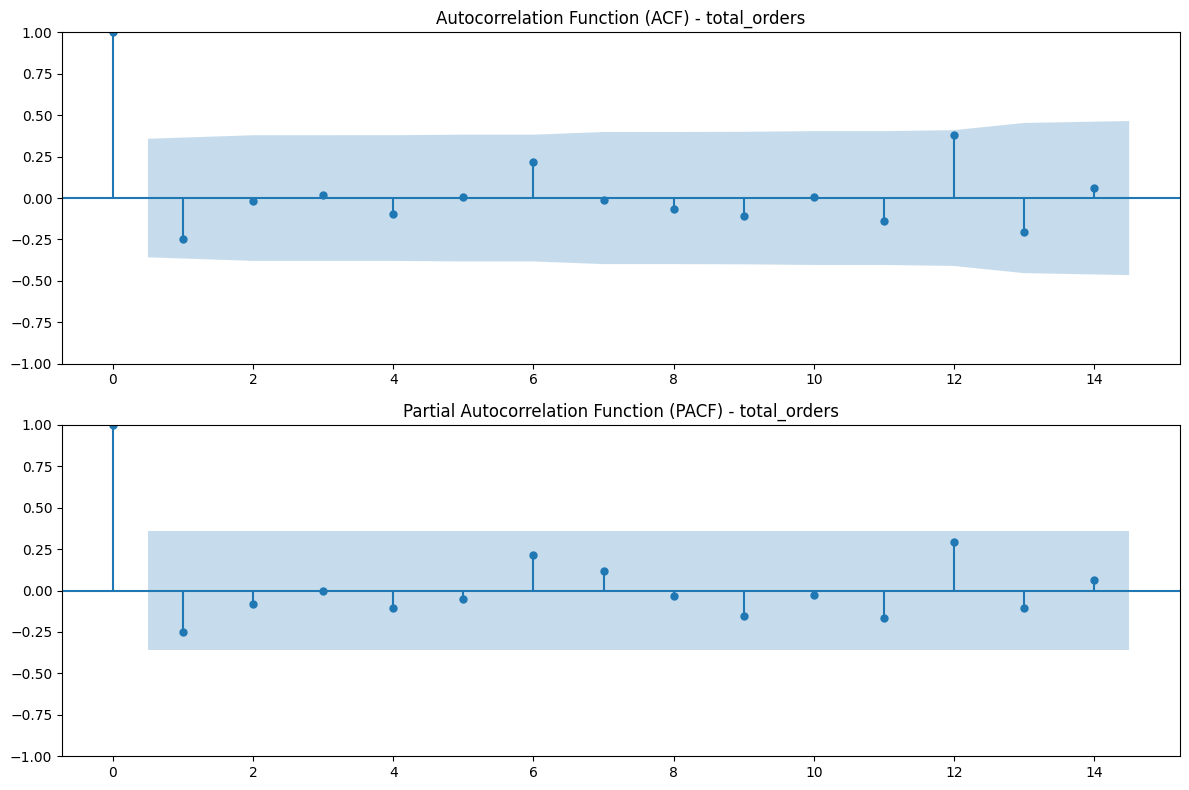


Order Selection Guidelines:
  • ACF cuts off at lag q → MA(q) component
  • PACF cuts off at lag p → AR(p) component
  • Both decay gradually → ARMA(p,q) component

  Recommended starting point: ARIMA(1,1,1) × (1,1,1,12)
  Note: Seasonal order uses s=12 (yearly pattern), training has 2.0 years


In [6]:
# Create ACF/PACF plots for first metric (as example)
metric = target_metrics[0]

# Calculate max lags (50% of training data)
max_lags = len(train_df) // 2 - 1
print(f"Training data: {len(train_df)} months → Max lags: {max_lags}")

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(train_df[metric], lags=max_lags, ax=axes[0])
axes[0].set_title(f'Autocorrelation Function (ACF) - {metric}')

# PACF plot
plot_pacf(train_df[metric], lags=max_lags, ax=axes[1])
axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {metric}')

plt.tight_layout()
plt.savefig('../results/sarimax_acf_pacf.png', dpi=150, bbox_inches='tight')
print(f"\n✓ Saved ACF/PACF plot: results/sarimax_acf_pacf.png")
plt.show()

print("\nOrder Selection Guidelines:")
print("  • ACF cuts off at lag q → MA(q) component")
print("  • PACF cuts off at lag p → AR(p) component")
print("  • Both decay gradually → ARMA(p,q) component")
print(f"\n  Recommended starting point: ARIMA(1,1,1) × (1,1,1,12)")
print(f"  Note: Seasonal order uses s=12 (yearly pattern), training has {len(train_df)//12:.1f} years")

## Section 5: Train SARIMAX Models

Train SARIMAX with order (2,1,2) × (1,1,1,12) for monthly seasonality.

In [7]:
def train_sarimax_model(train_data, metric):
    """
    Train SARIMAX model.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training time series
    metric : str
        Target metric column name
    
    Returns:
    --------
    SARIMAXResults
        Fitted SARIMAX model
    """
    print(f"\nTraining SARIMAX for {metric}...")
    
    # SARIMAX configuration
    # Simplified for limited training data (30 months)
    # (p,d,q): ARIMA order
    # (P,D,Q,s): Seasonal order with period s=12
    order = (1, 1, 1)  # Simplified from (2,1,2)
    seasonal_order = (1, 1, 1, 12)
    
    print(f"  Order: {order}")
    print(f"  Seasonal order: {seasonal_order}")
    print(f"  Note: Simplified due to limited training data (30 months)")
    
    # Create and fit model
    model = SARIMAX(
        train_data[metric],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    results = model.fit(disp=False)
    
    print(f"✓ Training complete")
    print(f"  AIC: {results.aic:.2f}")
    print(f"  BIC: {results.bic:.2f}")
    
    return results

# Train models for each metric
sarimax_models = {}

for metric in target_metrics:
    model = train_sarimax_model(train_df, metric)
    sarimax_models[metric] = model


Training SARIMAX for total_orders...
  Order: (1, 1, 1)
  Seasonal order: (1, 1, 1, 12)
  Note: Simplified due to limited training data (30 months)
✓ Training complete
  AIC: 69.79
  BIC: 65.28

Training SARIMAX for total_km_billed...
  Order: (1, 1, 1)
  Seasonal order: (1, 1, 1, 12)
  Note: Simplified due to limited training data (30 months)
✓ Training complete
  AIC: 94.17
  BIC: 89.66

Training SARIMAX for total_km_actual...
  Order: (1, 1, 1)
  Seasonal order: (1, 1, 1, 12)
  Note: Simplified due to limited training data (30 months)
✓ Training complete
  AIC: 102.60
  BIC: 98.10

Training SARIMAX for total_tours...
  Order: (1, 1, 1)
  Seasonal order: (1, 1, 1, 12)
  Note: Simplified due to limited training data (30 months)
✓ Training complete
  AIC: 72.68
  BIC: 68.18

Training SARIMAX for total_drivers...
  Order: (1, 1, 1)
  Seasonal order: (1, 1, 1, 12)
  Note: Simplified due to limited training data (30 months)
✓ Training complete
  AIC: 69.66
  BIC: 65.16

Training SARIMAX 

## Section 6: Generate Forecasts

In [8]:
# Generate forecasts
sarimax_forecasts = {}
future_forecasts = {}

# Forecast horizon: 18 months (validation + future)
forecast_horizon = 18

for metric, model in sarimax_models.items():
    # Generate forecast
    forecast = model.forecast(steps=forecast_horizon)
    
    # Extract validation period forecast (first len(val_df) months)
    val_forecast = forecast[:len(val_df)].values
    
    sarimax_forecasts[metric] = val_forecast
    future_forecasts[metric] = forecast
    
    print(f"\n{metric}:")
    print(f"  Validation forecast: {len(val_forecast)} months")
    print(f"  Full forecast: {len(forecast)} months")


total_orders:
  Validation forecast: 6 months
  Full forecast: 18 months

total_km_billed:
  Validation forecast: 6 months
  Full forecast: 18 months

total_km_actual:
  Validation forecast: 6 months
  Full forecast: 18 months

total_tours:
  Validation forecast: 6 months
  Full forecast: 18 months

total_drivers:
  Validation forecast: 6 months
  Full forecast: 18 months

revenue_total:
  Validation forecast: 6 months
  Full forecast: 18 months

external_drivers:
  Validation forecast: 6 months
  Full forecast: 18 months

vehicle_km_cost:
  Validation forecast: 6 months
  Full forecast: 18 months

vehicle_time_cost:
  Validation forecast: 6 months
  Full forecast: 18 months

total_vehicle_cost:
  Validation forecast: 6 months
  Full forecast: 18 months


## Section 7: Model Evaluation

In [9]:
def calculate_metrics(y_true, y_pred, model_name, metric_name):
    """Calculate forecast accuracy metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'model': model_name,
        'metric': metric_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Calculate metrics
results = []

for metric in target_metrics:
    y_true = val_df[metric].values
    y_pred = sarimax_forecasts[metric]
    
    metrics = calculate_metrics(y_true, y_pred, 'SARIMAX', metric)
    results.append(metrics)

results_df = pd.DataFrame(results)

print("\nSARIMAX Model Performance (Validation Period):")
print("="*80)
print(results_df.to_string(index=False))

# Compare with baseline and Prophet
try:
    baseline_df = pd.read_csv('../data/processed/baseline_metrics.csv')
    prophet_df = pd.read_csv('../data/processed/prophet_metrics.csv')
    
    print("\n" + "="*80)
    print("SARIMAX vs Prophet vs Best Baseline:")
    print("="*80)
    
    for metric in target_metrics:
        sarimax_mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
        prophet_mape = prophet_df[prophet_df['metric'] == metric]['MAPE'].values[0]
        baseline_best_mape = baseline_df[baseline_df['metric'] == metric]['MAPE'].min()
        
        print(f"\n{metric}:")
        print(f"  SARIMAX MAPE: {sarimax_mape:.2f}%")
        print(f"  Prophet MAPE: {prophet_mape:.2f}%")
        print(f"  Best Baseline MAPE: {baseline_best_mape:.2f}%")
        
        if sarimax_mape < prophet_mape:
            improvement = ((prophet_mape - sarimax_mape) / prophet_mape) * 100
            print(f"  → SARIMAX outperforms Prophet by {improvement:.1f}%")
        else:
            improvement = ((sarimax_mape - prophet_mape) / sarimax_mape) * 100
            print(f"  → Prophet outperforms SARIMAX by {improvement:.1f}%")
except:
    print("\n⚠️  Previous model metrics not found. Run notebooks 09-10 first.")


SARIMAX Model Performance (Validation Period):
  model             metric          MAE         RMSE        MAPE
SARIMAX       total_orders 3.380821e+04 3.625759e+04   24.375378
SARIMAX    total_km_billed 6.161198e+05 7.496196e+05    7.178547
SARIMAX    total_km_actual 3.038280e+06 3.498859e+06   12.335656
SARIMAX        total_tours 2.384923e+04 2.869966e+04   14.751714
SARIMAX      total_drivers 3.531084e+04 3.813022e+04   25.923282
SARIMAX      revenue_total 1.204876e+06 1.391662e+06    9.074145
SARIMAX   external_drivers 6.773508e+03 7.221401e+03   24.376511
SARIMAX    vehicle_km_cost 1.921397e+09 3.642881e+09 8655.701464
SARIMAX  vehicle_time_cost 1.501210e+06 1.606541e+06    4.902714
SARIMAX total_vehicle_cost 2.902486e+07 3.358164e+07   54.669286

SARIMAX vs Prophet vs Best Baseline:

total_orders:
  SARIMAX MAPE: 24.38%
  Prophet MAPE: 39.55%
  Best Baseline MAPE: 2.95%
  → SARIMAX outperforms Prophet by 38.4%

total_km_billed:
  SARIMAX MAPE: 7.18%
  Prophet MAPE: 37.35%
  Best

## Section 8: Residual Diagnostics

Analyze model residuals to validate assumptions.

In [10]:
# Diagnostic plots for first metric
metric = target_metrics[0]
model = sarimax_models[metric]

print(f"\nResidual Diagnostics - {metric}:")
print("="*50)

try:
    # Try to create diagnostic plot (may fail with limited data)
    fig = model.plot_diagnostics(figsize=(14, 8))
    plt.tight_layout()
    plt.savefig(f'../results/sarimax_diagnostics_{metric}.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved diagnostic plot: results/sarimax_diagnostics_{metric}.png")
    plt.show()
    
    print("\nInterpretation:")
    print("  • Standardized residuals: Should look like white noise")
    print("  • Histogram + KDE: Should be normally distributed")
    print("  • Q-Q plot: Points should follow the red line")
    print("  • Correlogram: Should be within confidence bands")
    
except ValueError as e:
    print(f"⚠️  Cannot generate full diagnostic plot with limited training data (30 months)")
    print(f"     Error: {e}")
    print(f"\n✓ Model trained successfully, but diagnostics require more data")
    print(f"     Recommendation: Use validation MAPE as primary performance metric")
    
    # Show basic residual statistics instead
    residuals = model.resid
    print(f"\nBasic Residual Statistics:")
    print(f"  Mean: {residuals.mean():.2f}")
    print(f"  Std Dev: {residuals.std():.2f}")
    print(f"  Min: {residuals.min():.2f}")
    print(f"  Max: {residuals.max():.2f}")


Residual Diagnostics - total_orders:
⚠️  Cannot generate full diagnostic plot with limited training data (30 months)
     Error: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

✓ Model trained successfully, but diagnostics require more data
     Recommendation: Use validation MAPE as primary performance metric

Basic Residual Statistics:
  Mean: -20515.68
  Std Dev: 51947.89
  Min: -146658.43
  Max: 131085.00


<Figure size 1400x800 with 0 Axes>

## Section 9: Forecast Visualization

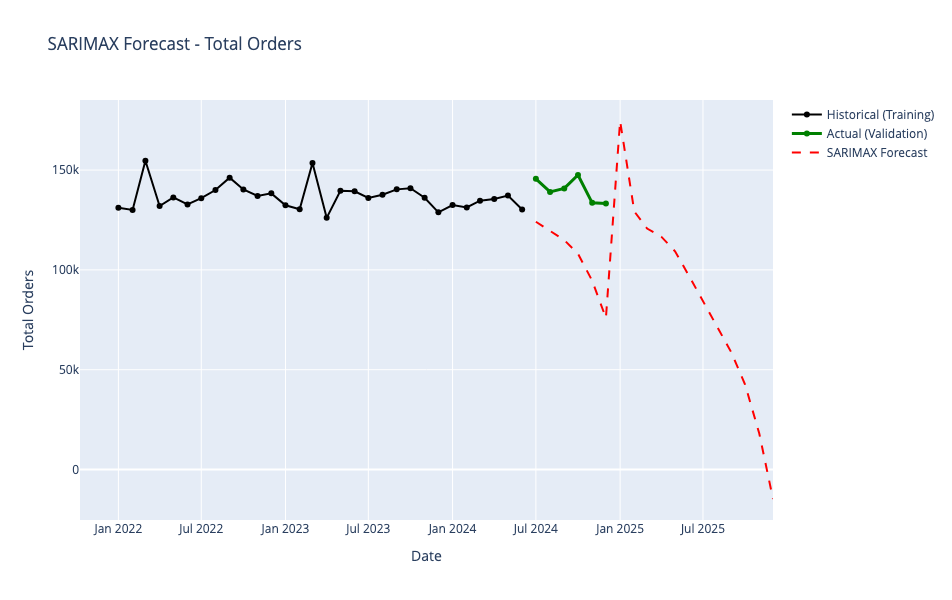


✓ Saved: results/sarimax_forecast_total_orders.html


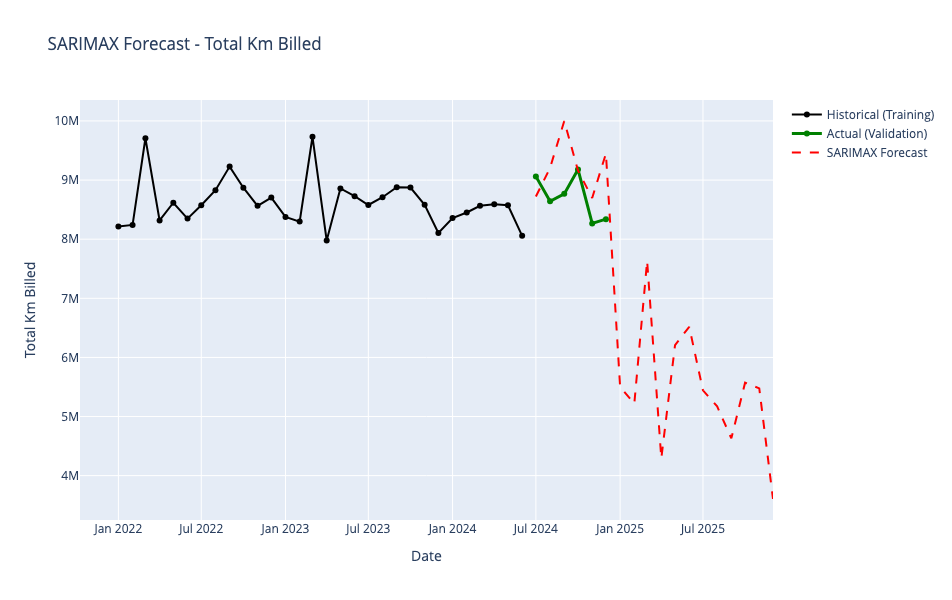


✓ Saved: results/sarimax_forecast_total_km_billed.html


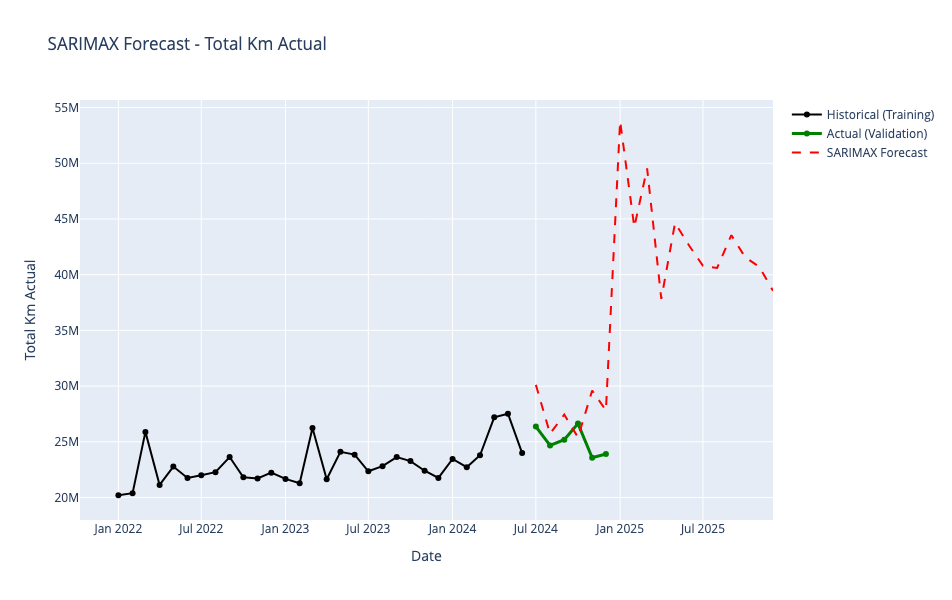


✓ Saved: results/sarimax_forecast_total_km_actual.html


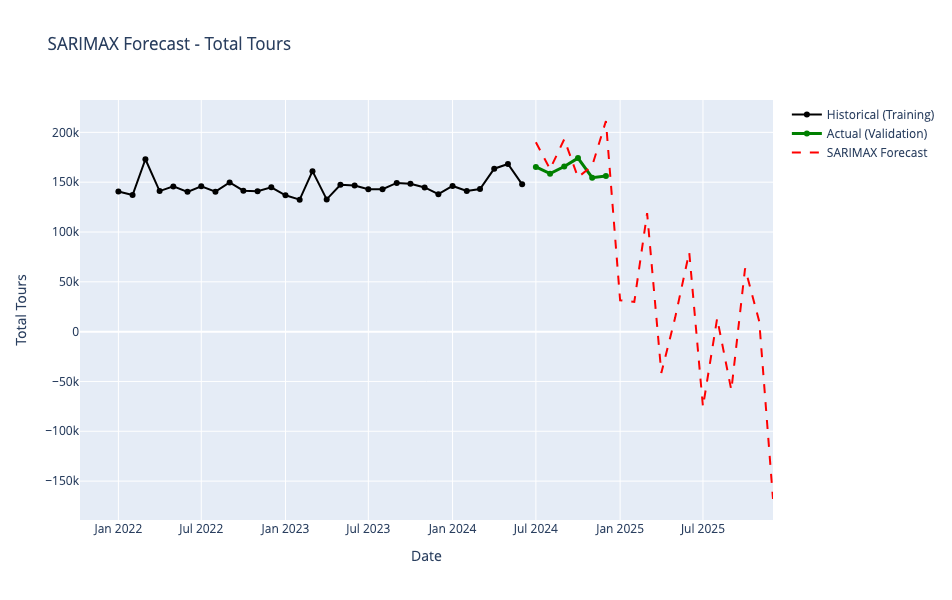


✓ Saved: results/sarimax_forecast_total_tours.html


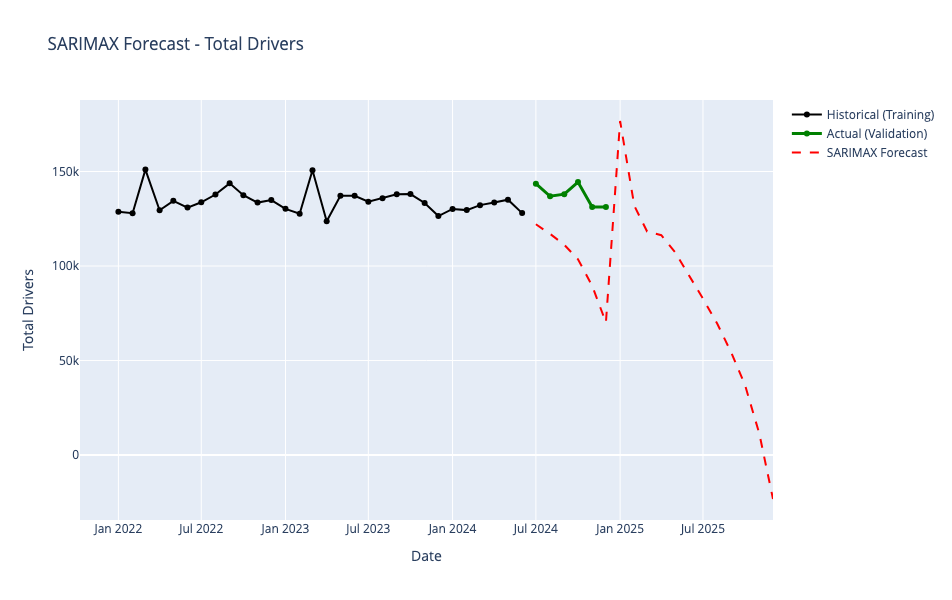


✓ Saved: results/sarimax_forecast_total_drivers.html


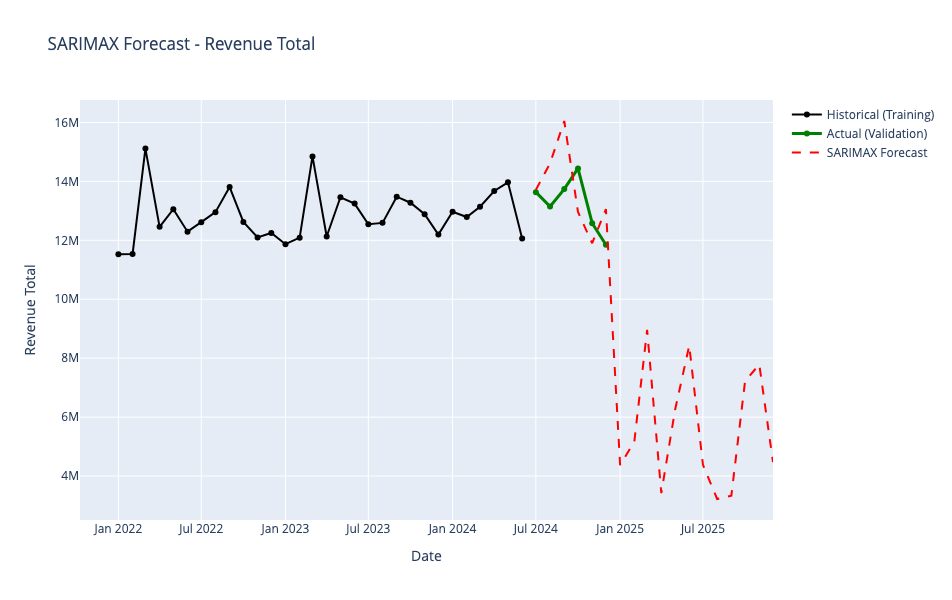


✓ Saved: results/sarimax_forecast_revenue_total.html


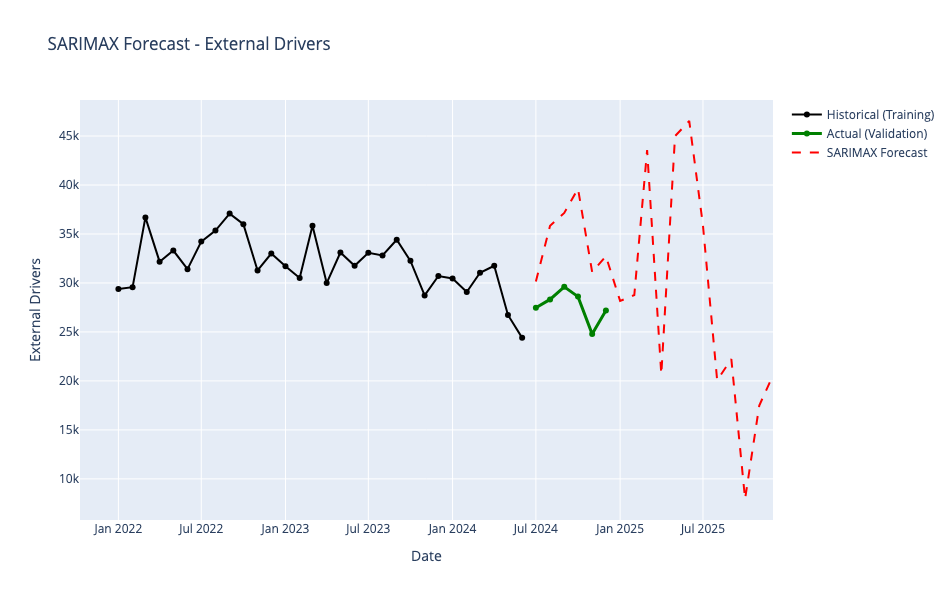


✓ Saved: results/sarimax_forecast_external_drivers.html


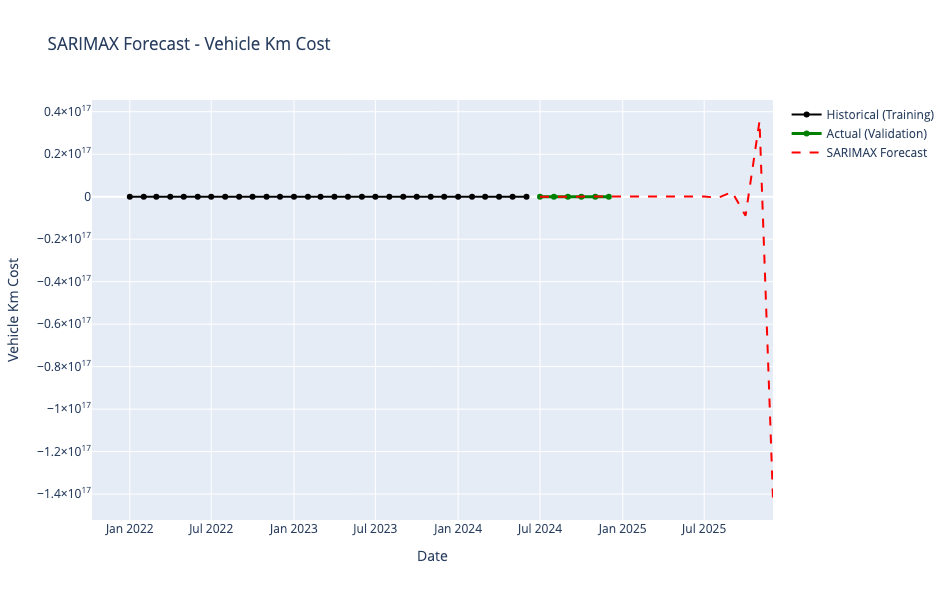


✓ Saved: results/sarimax_forecast_vehicle_km_cost.html


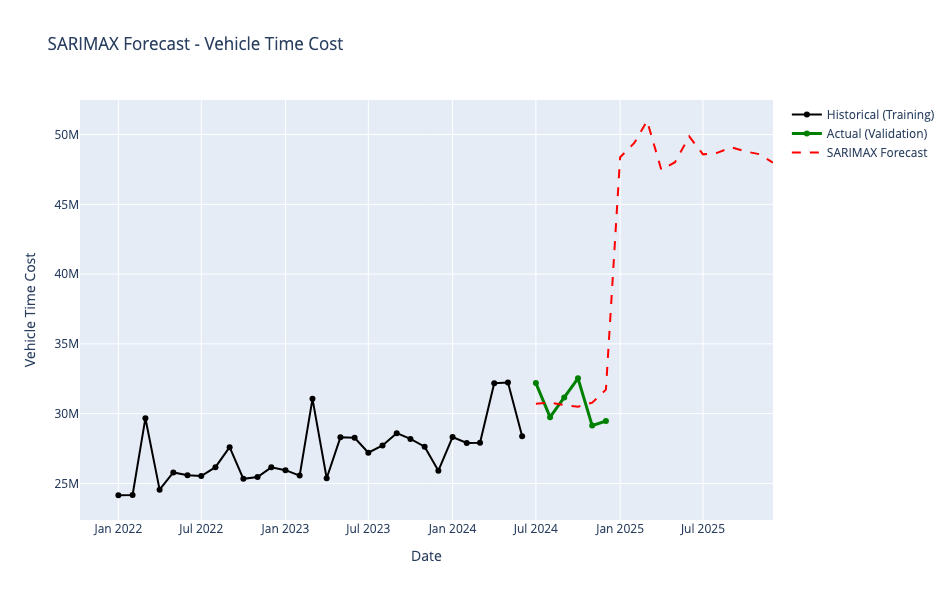


✓ Saved: results/sarimax_forecast_vehicle_time_cost.html


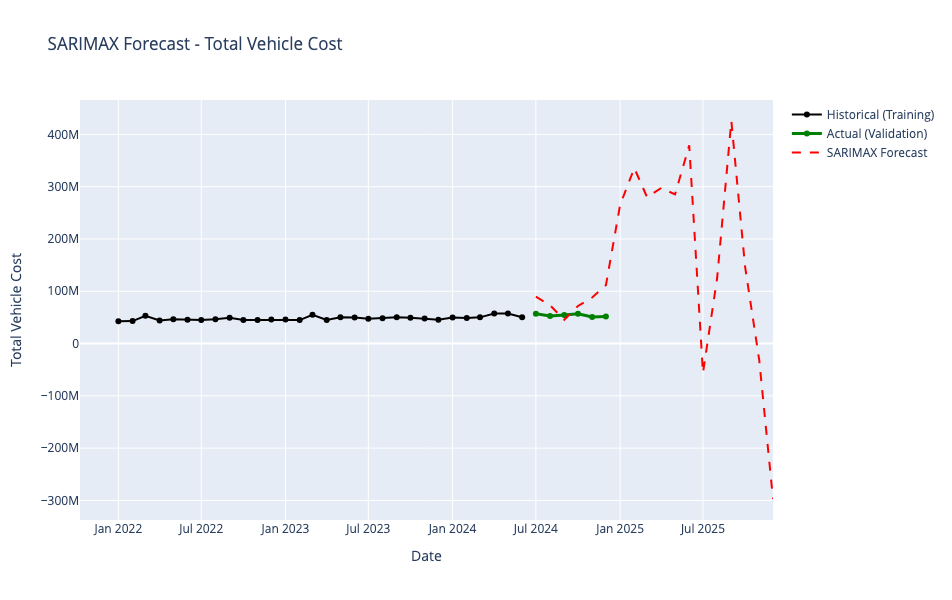


✓ Saved: results/sarimax_forecast_total_vehicle_cost.html


In [11]:
# Visualize forecasts
for metric in target_metrics:
    fig = go.Figure()
    
    # Historical training data
    fig.add_trace(
        go.Scatter(
            x=train_df['date'],
            y=train_df[metric],
            mode='lines+markers',
            name='Historical (Training)',
            line=dict(color='black', width=2)
        )
    )
    
    # Actual validation values
    if len(val_df) > 0:
        fig.add_trace(
            go.Scatter(
                x=val_df['date'],
                y=val_df[metric],
                mode='lines+markers',
                name='Actual (Validation)',
                line=dict(color='green', width=3)
            )
        )
    
    # SARIMAX forecast
    # Create future dates
    last_date = train_df['date'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=18, freq='MS')
    
    fig.add_trace(
        go.Scatter(
            x=future_dates,
            y=future_forecasts[metric],
            mode='lines',
            name='SARIMAX Forecast',
            line=dict(color='red', width=2, dash='dash')
        )
    )
    
    fig.update_layout(
        title=f"SARIMAX Forecast - {metric.replace('_', ' ').title()}",
        xaxis_title="Date",
        yaxis_title=metric.replace('_', ' ').title(),
        height=600,
        hovermode='x unified'
    )
    
    fig.show()
    
    # Save
    results_dir = Path('../results')
    results_dir.mkdir(exist_ok=True)
    fig.write_html(results_dir / f'sarimax_forecast_{metric}.html')
    print(f"\n✓ Saved: results/sarimax_forecast_{metric}.html")

## Section 10: Save Results

In [12]:
# Save performance metrics
output_dir = Path('../data/processed')
results_df.to_csv(output_dir / 'sarimax_metrics.csv', index=False)
print(f"✓ Saved metrics: data/processed/sarimax_metrics.csv")

# Save validation forecasts
if len(val_df) > 0:
    forecast_output = pd.DataFrame({
        'date': val_df['date'],
        'year_month': val_df['year_month'].astype(str)
    })
    
    for metric in target_metrics:
        forecast_output[metric] = sarimax_forecasts[metric]
    
    forecast_output.to_csv(output_dir / 'sarimax_forecast_validation.csv', index=False)
    print(f"✓ Saved validation forecasts: data/processed/sarimax_forecast_validation.csv")

# Save future forecasts (full 18 months)
last_date = train_df['date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=18, freq='MS')

future_output = pd.DataFrame({'date': future_dates})

for metric in target_metrics:
    future_output[metric] = future_forecasts[metric].values

future_output.to_csv(output_dir / 'sarimax_forecast_future.csv', index=False)
print(f"✓ Saved future forecasts: data/processed/sarimax_forecast_future.csv")

print(f"\n{'='*80}")
print(f"SARIMAX MODEL COMPLETE!")
print(f"{'='*80}")
print(f"\nKey Findings:")
for metric in target_metrics:
    mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
    print(f"  • {metric}: MAPE = {mape:.2f}%")
print(f"\nNext: Run notebook 12 for XGBoost model")

✓ Saved metrics: data/processed/sarimax_metrics.csv
✓ Saved validation forecasts: data/processed/sarimax_forecast_validation.csv
✓ Saved future forecasts: data/processed/sarimax_forecast_future.csv

SARIMAX MODEL COMPLETE!

Key Findings:
  • total_orders: MAPE = 24.38%
  • total_km_billed: MAPE = 7.18%
  • total_km_actual: MAPE = 12.34%
  • total_tours: MAPE = 14.75%
  • total_drivers: MAPE = 25.92%
  • revenue_total: MAPE = 9.07%
  • external_drivers: MAPE = 24.38%
  • vehicle_km_cost: MAPE = 8655.70%
  • vehicle_time_cost: MAPE = 4.90%
  • total_vehicle_cost: MAPE = 54.67%

Next: Run notebook 12 for XGBoost model
